# Raster Statistics

RasterFrames has a number of extension methods and columnar functions for performing analysis on tiles.

In [10]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
import pyspark
from pyspark.sql import SparkSession
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

resource_dir = Path('./samples').resolve()

spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()
# spark.sparkContext.setLogLevel("ERROR")

rf = spark.read.geotiff(resource_dir.joinpath("L8-B8-Robinson-IL.tiff").as_uri())

## Tile Statistics 

### Tile Dimensions

Get the nominal tile dimensions. Depending on the tiling there may be some tiles with different sizes on the edges.

In [7]:
rf.select(rf.spatialKeyColumn(), tileDimensions("tile")).show()

+-----------+---------------+
|spatial_key|dimension(tile)|
+-----------+---------------+
|      [2,1]|      [194,250]|
|      [0,0]|      [194,250]|
|      [3,1]|      [194,250]|
|      [1,0]|      [194,250]|
|      [3,0]|      [194,250]|
|      [0,1]|      [194,250]|
|      [1,1]|      [194,250]|
|      [2,0]|      [194,250]|
+-----------+---------------+



### Descriptive Statistics

#### NoData Counts

Count the numer of `NoData` and non-`NoData` cells in each tile.

In [ ]:
rf.select(rf.spatialKeyColumn(), noDataCells("tile"), dataCells("tile")).show()

#### Tile Mean

Compute the mean value in each tile.

In [ ]:
rf.select(rf.spatialKeyColumn(), tileMean("tile")).show(3)

## Aggregate Statistics

The `aggStats` function computes the same summary statistics as `tileStats`, but aggregates them over the whole 
RasterFrame.

In [17]:
rf.select(aggStats("tile")).show(truncate=False)

+-----------------------------------------------------------------+
|aggStats(tile)                                                   |
+-----------------------------------------------------------------+
|[387000,1000,7209.0,39217.0,10160.48549870801,3315238.5311127007]|
+-----------------------------------------------------------------+



## Plotting 
Data can be extracted and plotted with matplotlib. 

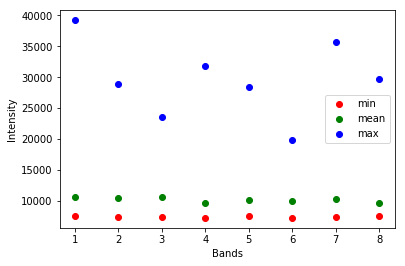

In [11]:
# Graph the mins, maxes, and means all at once
mins = list(map(lambda x: x[0], 
         rf.withColumn("stats", tileStats("tile")).select(rf.spatialKeyColumn(), "stats.*").select("min").collect()))
maxes = list(map(lambda x: x[0], 
         rf.withColumn("stats", tileStats("tile")).select(rf.spatialKeyColumn(), "stats.*").select("max").collect()))
means = list(map(lambda x: x[0], 
         rf.withColumn("stats", tileStats("tile")).select(rf.spatialKeyColumn(), "stats.*").select("mean").collect()))

bands = range(1, 9)
plt.xlabel("Bands")
plt.ylabel("Intensity")
plt.plot(bands, mins, 'ro', label='min')
plt.plot(bands, means, 'go', label='mean')
plt.plot(bands, maxes, 'bo', label='max')
plt.legend()
plt.show()

In [ ]:
rf.withColumn("stats", tileStats("tile")).select(rf.spatialKeyColumn(), "stats.*").show(3)

### Histogram

The `tileHistogram` function computes a histogram over the data in each tile. See the 
[GeoTrellis Histogram](geotrellis.raster.histogram.Histogram) documentation for details on what's
available in the resulting data structure.

In [14]:
hists = list(map(lambda x: (x[0].bins), rf.select(tileHistogram("tile")).collect()))

binList = []
for hist in hists:
    for bins in hist:
        binList.append((bins[0], bins[1]))

This is a plot of the histograms that were just computed across several of the tiles. 

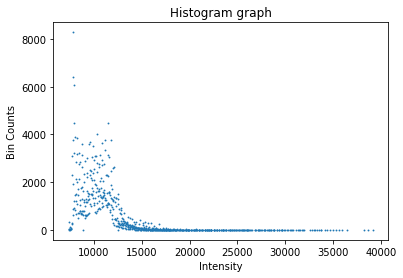

In [15]:
unzipped = list(zip(*binList))

fig, ax = plt.subplots()
plt.scatter(unzipped[0], unzipped[1], s=.75)
plt.xlabel("Intensity")
plt.ylabel("Bin Counts")
plt.title('Histogram graph')
plt.show()